# test.py jupyter notebook

This is the same as test.py but as a runnable notebook.

We assume you have set up your python environment. 

## Imports

In [1]:
import numpy as np
import itertools
from matplotlib import pyplot as plt
from joblib import Parallel, delayed


# sampler contains the classical and quantum enhanced MCMC sampler
from qemcmc.sampler import ClassicalMCMC, QeMCMC

# These are object useful to store the results of the MCMC simulation
from qemcmc.utils import plot_chains

# This helps you build an example Ising model
from qemcmc.model import EnergyModel


## Define model problem and algorithm parameters

In [2]:

# Define parameters
n = 15  # Number of spins in the system
coarse_graining_number = n
n_spins = n
reps = 5  # How many markov chains to produce
steps = 500  # Length of each markov chain
temp = 0.1  # Temperature of the system


# QeMCMC parameters
gamma = (0.3, 0.6)  # Relative strength of mixer hamiltonian
time = (1, 20)  # Time for hamiltonian simulation

# Make all combinations of subgroups that include coarse_graining_number of integers between 0 and n_spins -1
# Feroz, could we add this simple functionality to ModelMaker?
subgroups = list(itertools.combinations(range(n_spins), coarse_graining_number))


shape_of_J = (n_spins, n_spins)
J = np.round(np.random.normal(0, 1, shape_of_J), decimals=4)
J_tril = np.tril(J, -1)
J_triu = J_tril.transpose()
J = J_tril + J_triu

h = np.round(np.random.normal(0, 1, n_spins), decimals=4)

couplings = [h, J]
# why does the user have to calculate their own alpha? At least we should do it in model maker. Ask the user to input max_number of qubits, and we enumerate all combinations internally.
alpha = np.sqrt(n_spins) / np.sqrt(sum([J[i][j] ** 2 for i in range(n_spins) for j in range(i)]) + sum([h[j] ** 2 for j in range(n_spins)]))

model = EnergyModel(n=n_spins, couplings=couplings, alpha=alpha)
initial_states = model.initial_state



## Run classical MCMC

In [3]:

# Run classical (uniform and local) chains

uni_chains = []
for rep in range(reps):
    classical_uniform_MCMC = ClassicalMCMC(model, temp, method="uniform")
    uni_chain = classical_uniform_MCMC.run(steps, initial_state=initial_states[rep], name="classical uniform MCMC", verbose=False, sample_frequency=1)
    uni_chains.append(uni_chain)


loc_chains = []
for rep in range(reps):
    classical_local_MCMC = ClassicalMCMC(model, temp, method="local")
    loc_chain = classical_local_MCMC.run(steps, initial_state=initial_states[rep], name="classical local MCMC", verbose=False, sample_frequency=1)
    loc_chains.append(loc_chain)



## Run quantum MCMC

In [4]:
# Run the quantum algorithm
# The QeMCMC class is very similar to the MCMC class, but it has a few extra parameters that are specific to the quantum algorithm. 
# gamma and time are the hyperparameters that might need tuned for your specific problem.
# This may take a minute or so to run, depending on the number of steps and the size of the system. (takes 40s on my system for the default settings)

def run_qemcmc(rep):
    quantum_MCMC = QeMCMC(model, gamma=gamma, time=time, temp=temp)
    return quantum_MCMC.run(steps, initial_state=initial_states[rep], name="QeMCMC", verbose=True, sample_frequency=1)

# Run in parallel as they can take a while.
Qe_chains = Parallel(n_jobs=-1)(delayed(run_qemcmc)(rep) for rep in range(reps))
    

starting with:  111101000110000 with energy: 12.267299999999995
starting with:  101010001000101 with energy: 8.479699999999994
starting with:  111001111010011 with energy: -22.486699999999978
starting with:  110100111101011 with energy: -2.308899999999997
starting with:  110100111011101 with energy: 11.1595


Run QeMCMC: 100%|██████████| 500/500 [00:26<00:00, 18.59it/s]


## Analysis

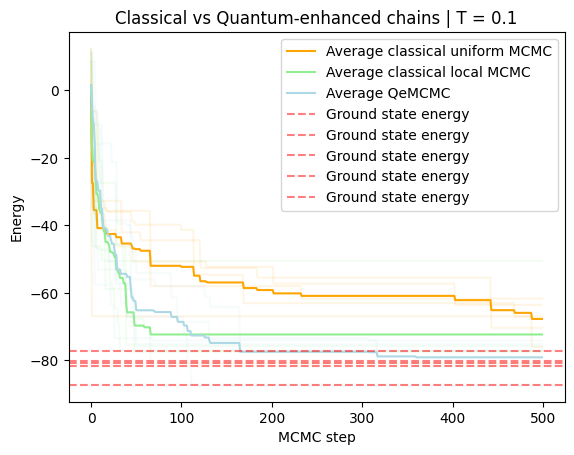

In [5]:

# Plot the list of chains with a helper function
# Dark line is for average ove rchains, transparenr lines are for each individual chains

plot_chains(uni_chains, "orange", "classical uniform MCMC")
plot_chains(loc_chains, "lightgreen", "classical local MCMC")
plot_chains(Qe_chains, "lightblue", "QeMCMC")
lowest_energies, _ = model.get_lowest_energies(5)
for i in range(len(lowest_energies)):
    plt.axhline(lowest_energies[i], color="red", linestyle="--",alpha=0.5, label="Ground state energy")


plt.xlabel("MCMC step")
plt.ylabel("Energy")
plt.title("Classical vs Quantum-enhanced chains | T = {}".format(temp))
plt.legend()
plt.show()


## Convergence
Hopefully it should be clear that fewer of the quantum-enhanced chains get stuck in local minima, and are able to fully traverse the state space. This results in the average energy across multiple chains reaching the stationary distribution earlier than the classical local proposal. Of course, chains may look like they have thermalised, however they are actually stuck in non-global minima.

## Temperature dependence

The QeMCMC is much more effective at lower temperatures so changing the initial temperature should result in different outcomes. Have a play with the temperature parameter and see how it affects convergence. For low temperatures T<0.1, local classical chains are highly likely to get stuck in local minima and only converge to the stationary distribution extremely slowly.

## Size dependence

The difficulty of the sampling problem is exponentially related to the size of the Ising model. Play with the size of the system and see how the problem becomes difficult. Also change the number of qubits used and see how the quantum method improves with more qubits.

## Random nature of MCMC

Please note that to gain a true insight into the efficacy of these methods, one needs to average over many different chains, on many different model instances. Some model instances are naturally much harder and some random starting positions are lucky - they are close to the global minima. This means that the simple experiment above may give unreliable results, but if you run it enough times, a clear trend should be clear.